<a href="https://colab.research.google.com/github/Ossiumx/Previsao-de-Volume-de-madeira/blob/main/Primeira_Avalia%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=5dfa52669f8ad812a29c383eb4a698d6ea3580bc440957ca4ef58b9303b7536f
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
# Importar Biblioteca

# manipulação e análise de dados
import pandas as pd
import numpy as np

# visualização de dados
import matplotlib.pyplot as plt # criação de gráficos e visualizações de dados.
import seaborn as sns

# pré-processamento e seleção de modelos
from sklearn.model_selection import KFold # validação cruzada.
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, cross_val_predict # avaliação de desempenho.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, mean_absolute_percentage_error # métricas de avaliação de modelos.
from eli5.sklearn import PermutationImportance # importancia dos recursos
from sklearn.metrics import make_scorer # criação de métricas de avaliação de modelos.
from sklearn.utils import check_array # validação de arrays.

# modelos de aprendizado de máquina
import xgboost as xgb # implementação de algoritmos de aprendizado de máquina.
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor # modelos de aprendizado de máquina.
from sklearn.tree import DecisionTreeRegressor # modelos de aprendizado de máquina.
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import eli5

In [ ]:
# Carregar os dados
'''
from google.colab import drive
drive.mount('/content/drive')
dados = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/dadoslimposempresa.xlsx')
'''

dados = pd.read_excel("dadoslimposempresa.xlsx")

Mounted at /content/drive


In [ ]:
# Visualizar os dados

dados.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10941 entries, 0 to 10940
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GENE          10941 non-null  object 
 1   DENSIDADE     10941 non-null  float64
 2   IDADE         10941 non-null  float64
 3   DAP           10941 non-null  float64
 4   HT            10941 non-null  float64
 5   G             10941 non-null  float64
 6   VOLUME        10941 non-null  float64
 7   LNVOL         10941 non-null  float64
 8   LNHT          10941 non-null  float64
 9   LNDAP         10941 non-null  float64
 10  LNG           10941 non-null  float64
 11  DAPHT         10941 non-null  float64
 12  DAPQUADHT     10941 non-null  float64
 13  DAPQUAD       10941 non-null  float64
 14  HTQUAD        10941 non-null  float64
 15  LNDAPHT       10941 non-null  float64
 16  LNDAPQUADHT   10941 non-null  float64
 17  LNHTQUAD      10941 non-null  float64
 18  LOGVOL        10941 non-nu

In [ ]:
# Separar as variáveis de entrada (X) e a variável de saída (y)

x = dados.drop(["RAIZVOL","VOLUME","LNVOL","LOGVOL","UMDIVRAIZVOL","GENE","RAIZPIVOL"], axis=1)
y = dados["RAIZVOL"]

In [ ]:
# Dividir os dados em conjunto de treinamento e conjunto de teste
x_train, x_separated, y_train, y_separated = train_test_split(x, y, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(x_separated, y_separated, test_size=0.5, random_state=42)


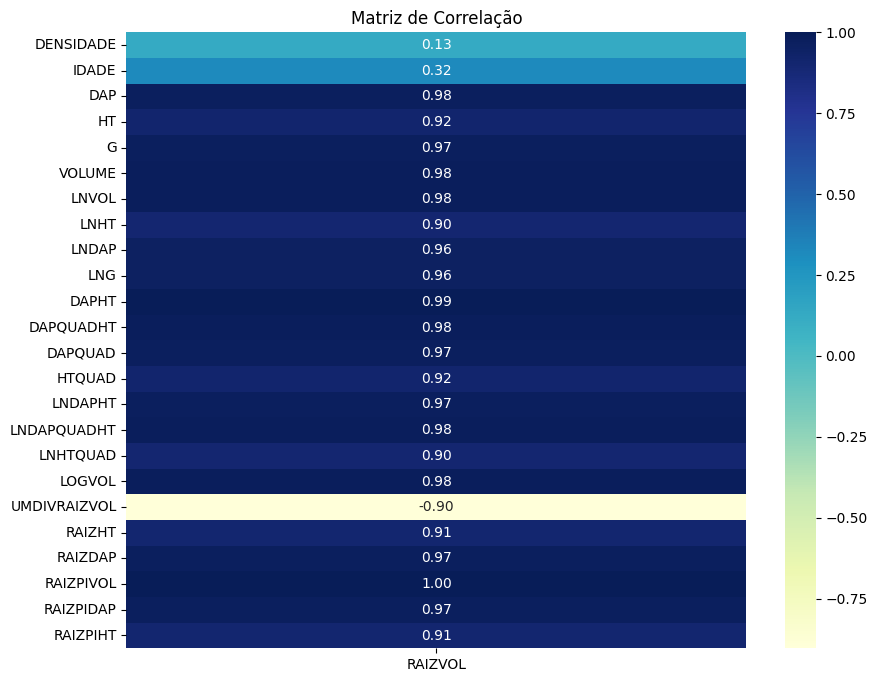

In [ ]:
# Gerar grafico de correlação

corr = dados.corr(numeric_only=True)['RAIZVOL'].drop('RAIZVOL').to_frame()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
plt.title("Matriz de Correlação")
plt.show()


In [ ]:
# Validação cruzada para todos os modelos

# Função para validação cruzada

def evaluate_model(model, x_train, y_train, cv=5):
    # Realizar validação cruzada e obter as pontuações
    scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    # Converter as pontuações para RMSE
    rmse_scores = np.sqrt(-scores)
    rmse_scores = np.round(rmse_scores, 6)

    # Realizar validação cruzada e obter as previsões
    predictions = cross_val_predict(model, x_train, y_train, cv=cv)

    # Calcular o MAPE
    mape = np.mean(np.abs((y_train - predictions) / y_train)) * 100
    mape = round(mape, 2)

    # Calcular o R2
    r2 = r2_score(y_train, predictions)
    r2 = round(r2, 2)

    # calcular o mae

    mae = mean_absolute_error(y_train, predictions)
    mae = round(mae, 6)

    return rmse_scores, mape, r2, mae

In [ ]:
# Lista de modelos para validação
models = [
    ('Random Forest', RandomForestRegressor()),
    ('Linear Regression', LinearRegression()),
    ('XGBoost', xgb.XGBRegressor()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor())
]

# Dicionário para armazenar os resultados
results = {'Model': [], 'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': []}

In [ ]:
# Avaliar cada modelo
for name, model in models:
    rmse_scores, mape, r2, mae = evaluate_model(model, x_train, y_train, cv=5)
    results['Model'].append(name)
    results['RMSE'].append(np.mean(rmse_scores))
    results['MAPE'].append(mape)
    results['MAE'].append(mae)
    results['R2'].append(r2)

# Converter os resultados em um DataFrame
results_df = pd.DataFrame(results)

# Salvar os resultados em um arquivo Excel
results_df.to_excel('métricas_modelos.xlsx', index=False)

In [ ]:
# features mais importantes para cada modelo
models = [
    ('Random Forest', RandomForestRegressor()),
    ('Linear Regression', LinearRegression()),
    ('XGBoost', xgb.XGBRegressor()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor())
]

In [ ]:
# Função para gerar as features mais importantes de cada modelo e depois gerar um arquivo xlsx com os dados
def get_important_features(model, x_train, y_train):
    # Treinar o modelo
    model.fit(x_train, y_train)

    # Calcular a importância das variáveis usando Permutation Importance
    perm = PermutationImportance(model, random_state=42).fit(x_train, y_train)
    feature_importances = eli5.explain_weights_df(perm, feature_names=x_train.columns.tolist())

    # Obter as variáveis com importância não nula
    important_features = feature_importances[feature_importances['weight'] != 0]['feature']

    # Adicionar a variável dependente
    important_features = important_features.append(pd.Series(['RAIZVOL']))

    return important_features

In [ ]:
# Dicionário para armazenar os resultados
results = {'Model': [], 'Important Features': []}

# Obter as características importantes para cada modelo
for name, model in models:
    important_features = get_important_features(model, x_val, y_val)
    results['Model'].append(name)
    results['Important Features'].append(important_features)

    # Salvar as variáveis importantes em um arquivo Excel separado para cada modelo
    important_data = dados[important_features]
    important_data.to_excel(f'{name}_important_data.xlsx', index=False)

<ipython-input-18-645d51bdc593>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  important_features = important_features.append(pd.Series(['RAIZVOL']))
<ipython-input-18-645d51bdc593>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  important_features = important_features.append(pd.Series(['RAIZVOL']))
<ipython-input-18-645d51bdc593>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  important_features = important_features.append(pd.Series(['RAIZVOL']))
<ipython-input-18-645d51bdc593>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  important_features = important_features.append(pd.Series(['RAIZVOL']))
<ipython-input-18-645d51bdc5